In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline

계절성 차분

In [3]:
ts_diff = ts - ts.shift()
plt.figure(figsize=(22,8))
plt.plot(ts_diff)
plt.show()

NameError: ignored

In [ ]:
ts_diff = ts_diff[1:]

운량(ca)

In [4]:
seoul = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이터/찐최종 데이터/구글클라우드플랫폼/seoul_final.csv', encoding='UTF-8')
busan = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이터/찐최종 데이터/구글클라우드플랫폼/busan_final.csv', encoding='UTF-8')
kangwon = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이터/찐최종 데이터/구글클라우드플랫폼/kangwon_final.csv', encoding='UTF-8')

In [5]:
seoul_data = seoul.loc[seoul.date < '2022-01-01',:]
seoul_data

,Unnamed: 0,date,add,ca,avg_ta,sum_rn,new_wd,new_ws
0,1,2012-01-01,서울,5.1,-2.7,0.000000,-606.6210,-9.6589
1,2,2012-01-02,서울,2.9,-4.6,0.000000,-501.4768,-5.1131
2,3,2012-01-03,서울,7.5,-4.3,0.000000,-607.3124,-7.7681
3,4,2012-01-04,서울,1.1,-6.8,0.000000,-613.9938,-7.9552
4,5,2012-01-05,서울,0.0,-5.2,0.000000,-581.0362,-5.4605
...,...,...,...,...,...,...,...,...
3648,3649,2021-12-27,서울,3.1,-7.5,0.000000,-322.2190,-4.4607
3649,3650,2021-12-28,서울,4.1,-3.7,0.000000,-213.7330,-4.0054
3650,3651,2021-12-29,서울,5.1,1.1,0.006897,-475.1588,-8.1641
3651,3652,2021-12-30,서울,2.0,-3.0,0.000000,-592.3326,-9.7587


In [8]:
#date 형식 변경
date = []
ogn_date = seoul_data['date']
for i in range(seoul_data.shape[0]) :
    a = str(ogn_date.iloc[i,])
    a = pd.to_datetime(a)
    date.append(a)
seoul_data['date'] = date

seoul_df = seoul_data.loc[:,['date', 'ca']]

In [9]:
seoul_df

,date,ca
0,2012-01-01,5.1
1,2012-01-02,2.9
2,2012-01-03,7.5
3,2012-01-04,1.1
4,2012-01-05,0.0
...,...,...
3648,2021-12-27,3.1
3649,2021-12-28,4.1
3650,2021-12-29,5.1
3651,2021-12-30,2.0


In [10]:
#시계열 분해법
seoul_ca = seoul_df
seoul_ca.index = seoul_ca['date']
seoul_ca = seoul_ca.drop('date', axis = 1)
seoul_ca

,ca
date,
2012-01-01,5.1
2012-01-02,2.9
2012-01-03,7.5
2012-01-04,1.1
2012-01-05,0.0
...,...
2021-12-27,3.1
2021-12-28,4.1
2021-12-29,5.1


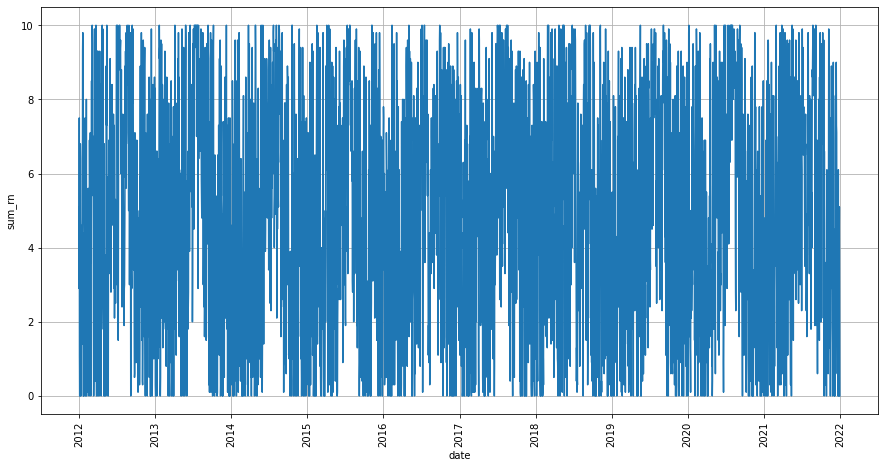

In [11]:
#시계열 그래프
plt.figure(figsize=[15, 7.5])
plt.plot(seoul_df['date'], seoul_df['ca'])
plt.xlabel("date")
plt.ylabel("sum_rn")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

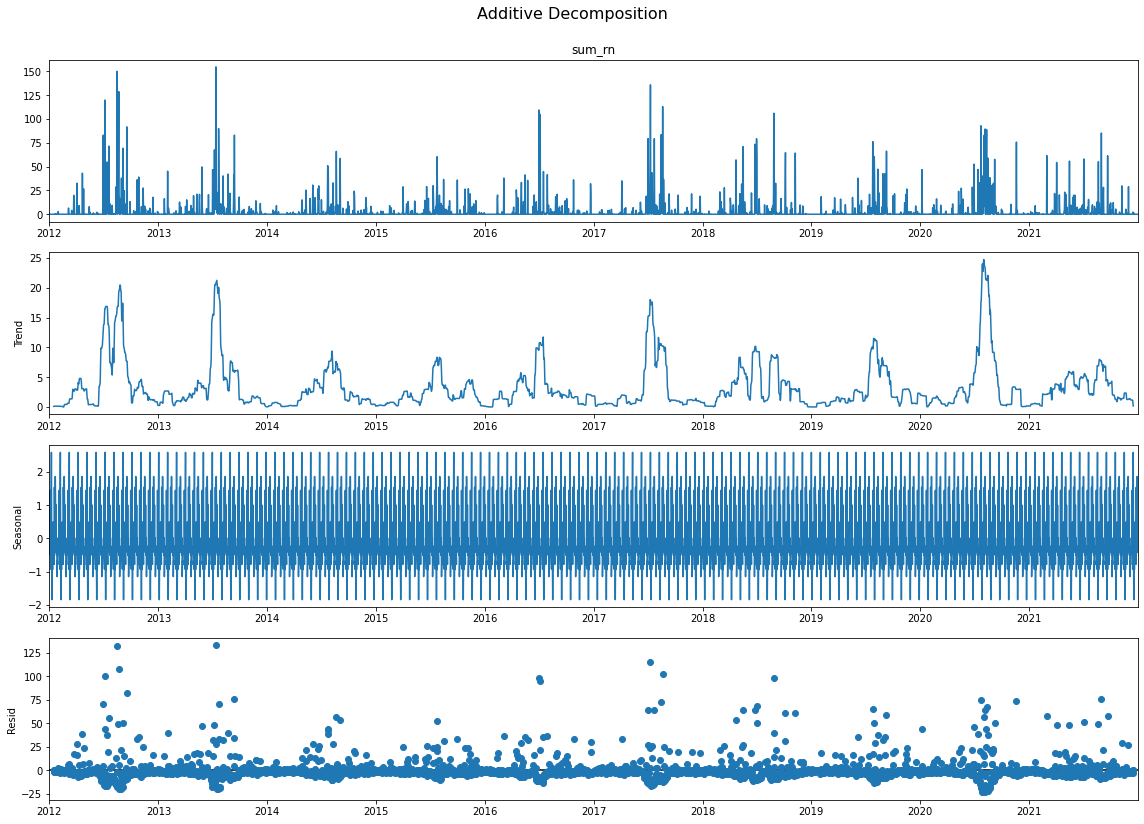

In [ ]:
from dateutil.parser import parse
from statsmodels.tsa.seasonal import seasonal_decompose

additive_decomposition = seasonal_decompose(seoul_df['sum_rn'], model='additive', period=30)

plt.rcParams.update({'figure.figsize' : (16, 12)})
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

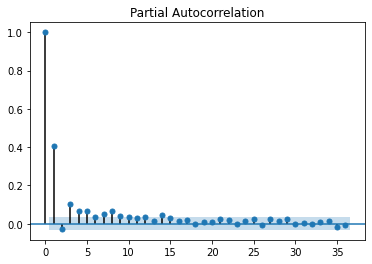

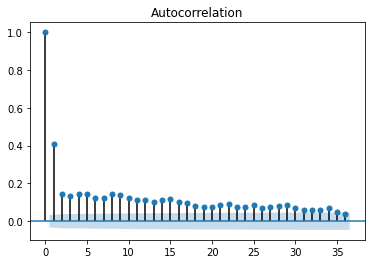

In [12]:
#자기상관계수 확인
plot_pacf(seoul_ca['ca']);
plot_acf(seoul_ca['ca']);

In [ ]:
#ADF test
ad_fuller_result = adfuller(seoul_ca['ca'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}') 

ADF Statistic: -8.919642932841747
p-value: 1.0495555268928476e-14


In [17]:
#백색잡음 검정(Ljung-Box Test)
import statsmodels.api as sm
sm.stats.acorr_ljungbox(seoul_ca['ca'], lags=[12], return_df=True)

,lb_stat,lb_pvalue
12,1296.241546,3.215003e-270


In [13]:
#SARIMA model
def optimize_SARIMA(parameters_list, d, D, s, exog):    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [14]:
# 파라미터 조합 리스트 
p = range(0, 3, 1) #pacf에서 수렴하기 직전값
d = 1 #추세 존재 여부
q = range(0, 3, 1) #adf테스트 및 추세 확인
P = range(0, 3, 1) #pacf에서 계절성이 주기 반복횟수
D = 1 #계절성 존재 여부
Q = range(0, 3, 1) #acf기준 계절성 주기 반복횟수
s = 12 #계절성 주기
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

81


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 12, seoul_ca["ca"])
result_df

  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 1)",17851.098719
1,"(1, 2, 0, 1)",17852.384377
2,"(0, 2, 0, 2)",17852.694137
3,"(0, 2, 1, 1)",17852.708348
4,"(0, 2, 1, 2)",17852.937714
...,...,...
76,"(0, 1, 0, 0)",20622.345692
77,"(0, 0, 1, 0)",20632.118503
78,"(2, 0, 0, 0)",20989.736589
79,"(1, 0, 0, 0)",21353.215032


In [15]:
#가장 aic 낮은 파라미터 모델 적합 (p, d, q) (P, D, Q, s) 
best_model = SARIMAX(seoul_ca, order=(0, 1, 2), seasonal_order=(0, 1, 1, 12), enforce_stationarity=True, enforce_invertibility=True)
res = best_model.fit()
print(res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                   ca   No. Observations:                 3653
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -8921.549
Date:                              Thu, 17 Nov 2022   AIC                          17851.099
Time:                                      06:28:46   BIC                          17875.898
Sample:                                  01-01-2012   HQIC                         17859.932
                                       - 12-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6041      0.016    -37.900      0.000      -0.635      -0.573
ma.L2         -0.32

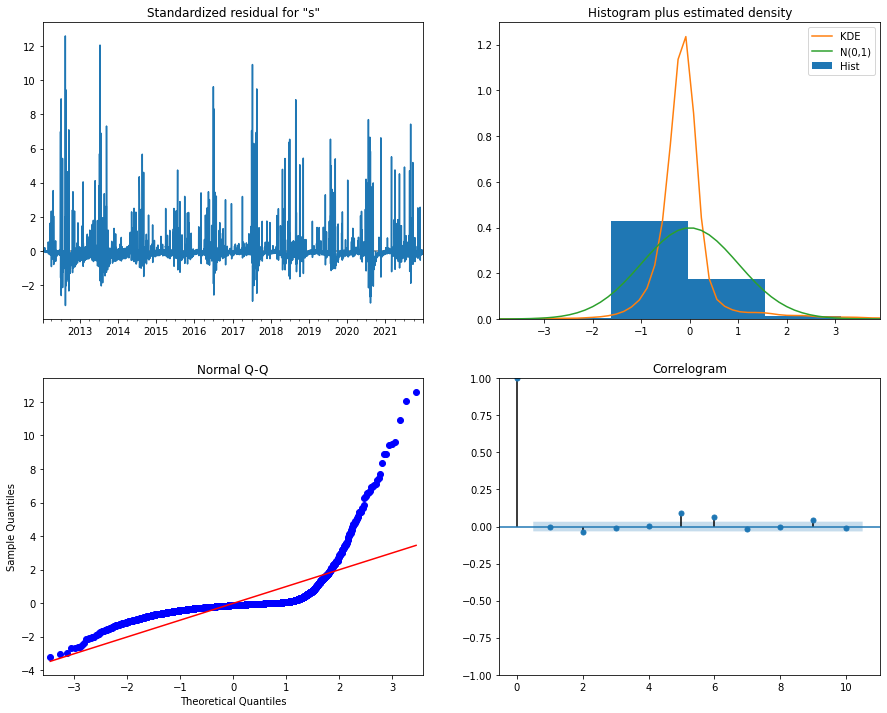

In [ ]:
#잔차 진단 
res.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
seoul[seoul['date'] == '2022-01-01']["ca"]

3653    1.4
Name: ca, dtype: float64

In [ ]:
res.forecast(365)    

2022-01-01    2.300489
2022-01-02    3.181058
2022-01-03    3.327122
2022-01-04    3.128769
2022-01-05    3.174492
                ...   
2022-12-27    3.087125
2022-12-28    3.140176
2022-12-29    3.286240
2022-12-30    3.087887
2022-12-31    3.133610
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

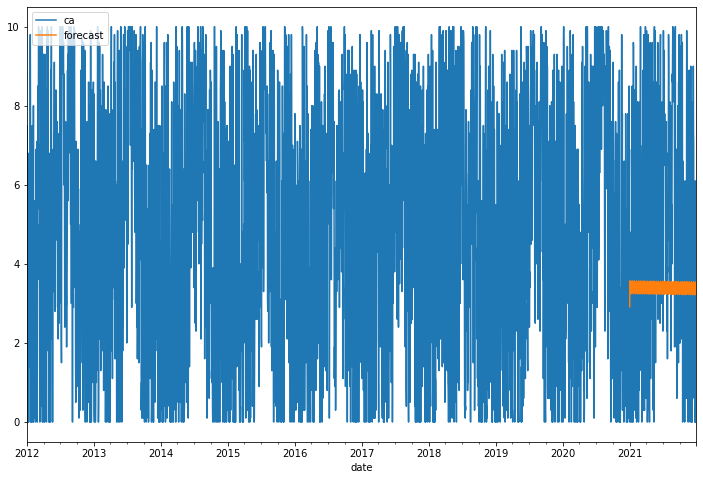

In [16]:
#forecast 시각화
seoul_df['forecast']=res.predict(start='2021-01-01', end='2021-12-31', dynamic=True)
seoul_df[['ca','forecast']].plot(figsize=(12,8))
plt.show()

In [ ]:
#실제 2022년 데이터와 비교
ca_pred = seoul.loc[seoul.date > '2021-12-31',:]

date = []
ogn_date = ca_pred['date']
for i in range(ca_pred.shape[0]) :
    a = str(ogn_date.iloc[i,])
    a = pd.to_datetime(a)
    date.append(a)
ca_pred['date'] = date

ca_pred = ca_pred.loc[:,['date', 'ca']]
ca_pred

,date,ca
3653,2022-01-01,1.4
3654,2022-01-02,4.1
3655,2022-01-03,4.9
3656,2022-01-04,0.0
3657,2022-01-05,7.3
...,...,...
3952,2022-10-27,1.4
3953,2022-10-28,1.5
3954,2022-10-29,1.1
3955,2022-10-30,1.1


In [ ]:
#미래 예측
result_ca = res.predict(start = 3653, end = 3956, dynamic= True)
result_ca

2022-01-01    2.300489
2022-01-02    3.181058
2022-01-03    3.327122
2022-01-04    3.128769
2022-01-05    3.174492
                ...   
2022-10-27    3.049019
2022-10-28    3.093938
2022-10-29    3.146990
2022-10-30    3.293053
2022-10-31    3.094701
Freq: D, Name: predicted_mean, Length: 304, dtype: float64

In [ ]:
# 마지막 5일의 예측 데이터 (2021-04-15 ~ 2021-04-19)
pred_y = result_ca.tolist()

# 실제 5일의 데이터 (2021-04-15 ~ 2021-04-19)
test_y = ca_pred.ca.values

# 마지막 5일의 예측 데이터 최소값
pred_y_lower = []
# 마지막 5일의 예측 데이터 최대값
pred_y_upper = []

for lower_upper in result_ca[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

TypeError: ignored

In [ ]:
plt.figure(figsize=(15, 10))

# 모델이 예측한 가격 그래프
plt.plot(pred_arima_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

plt.legend(['예측값', '최저값','최대값','실제값'])
plt.title("값 비교")
plt.show()

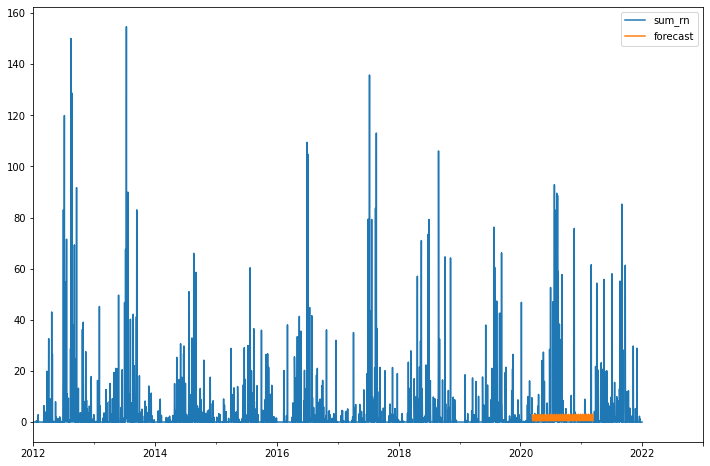

In [ ]:
#예측한 결과 시각화
from pandas.tseries.offsets import DateOffset
future_dates=[seoul_df.index[-1]+ DateOffset(days=x)for x in range(0,365)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=seoul_df.columns)

future_datest_df.tail()

future_df=pd.concat([seoul_df,future_datest_df])

future_df['forecast'] = res.predict(start = 2994, end = 3358, dynamic= True)
future_df[['sum_rn', 'forecast']].plot(figsize=(12, 8))
plt.show()

강수량

In [ ]:
#date 형식 변경
date = []
ogn_date = seoul_data['date']
for i in range(seoul_data.shape[0]) :
    a = str(ogn_date.iloc[i,])
    a = pd.to_datetime(a)
    date.append(a)
seoul_data['date'] = date

In [ ]:
seoul_df = seoul_data.loc[:,['date', 'sum_rn']]
seoul_df

,date,sum_rn
0,2012-01-01,0.000000
1,2012-01-02,0.000000
2,2012-01-03,0.000000
3,2012-01-04,0.000000
4,2012-01-05,0.000000
...,...,...
3648,2021-12-27,0.000000
3649,2021-12-28,0.000000
3650,2021-12-29,0.006897
3651,2021-12-30,0.000000


In [ ]:
#시계열 분해법
seoul_wd = seoul_df
seoul_wd.index = seoul_wd['date']
seoul_wd = seoul_wd.drop('date', axis = 1)
seoul_wd

,sum_rn
date,
2012-01-01,0.000000
2012-01-02,0.000000
2012-01-03,0.000000
2012-01-04,0.000000
2012-01-05,0.000000
...,...
2021-12-27,0.000000
2021-12-28,0.000000
2021-12-29,0.006897


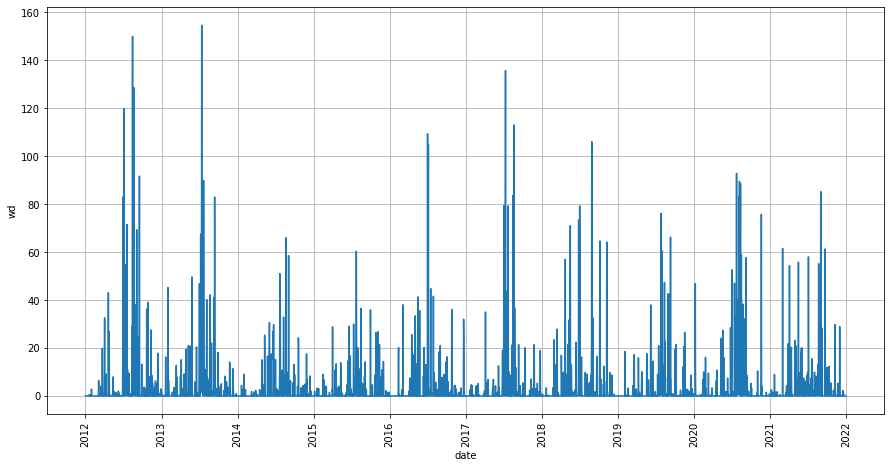

In [ ]:
#시계열 그래프
plt.figure(figsize=[15, 7.5])
plt.plot(seoul_df['date'], seoul_df['sum_rn'])
plt.xlabel("date")
plt.ylabel("wd")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [ ]:
# 계절성 차분
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
X = seoul_wd["sum_rn"].values
days_in_year = 365
differenced = difference(X, days_in_year)

In [ ]:
differenced

array([0.        , 1.58333333, 0.        , ..., 0.        , 0.        ,
       0.        ])

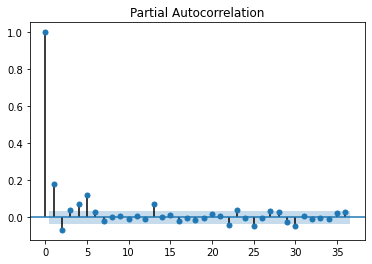

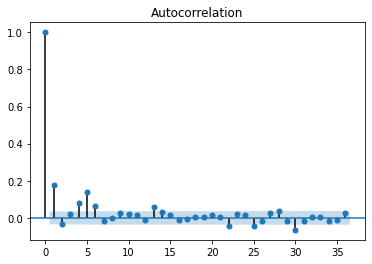

In [ ]:
#자기상관계수 확인
plot_pacf(differenced);
plot_acf(differenced);

In [ ]:
#ADF test
ad_fuller_result = adfuller(differenced)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}') 

ADF Statistic: -10.330684027820647
p-value: 2.8478405151121755e-18


In [ ]:
# 파라미터 조합 리스트 
p = range(0, 3, 1) #pacf에서 수렴하기 직전값
d = 1 #추세 존재 여부
q = range(0, 3, 1) #adf테스트 및 추세 확인
P = range(0, 3, 1) #pacf에서 계절성이 주기 반복횟수
D = 1 #계절성 존재 여부
Q = range(0, 3, 1) #acf기준 계절성 주기 반복횟수
s = 12 #계절성 주기
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

81


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 12, seoul_wd["wd"])
result_df

  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 1, 0, 1)",26243.960252
1,"(1, 1, 0, 2)",26245.655669
2,"(1, 1, 1, 1)",26245.840152
3,"(2, 2, 0, 1)",26245.938625
4,"(1, 2, 0, 1)",26245.958443
...,...,...
76,"(0, 0, 2, 0)",28392.310514
77,"(0, 0, 1, 0)",28717.090798
78,"(2, 0, 0, 0)",28818.468743
79,"(1, 0, 0, 0)",29053.761985


In [ ]:
#가장 aic 낮은 파라미터 모델 적합 (p, d, q) (P, D, Q, s) 
best_model = SARIMAX(differenced, order=(1, 1, 1), seasonal_order=(2, 1, 2, 12), enforce_stationarity=True, enforce_invertibility=True)
res = best_model.fit()
print(res.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                 3288
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood              -13580.895
Date:                                 Sat, 12 Nov 2022   AIC                          27175.791
Time:                                         06:53:26   BIC                          27218.449
Sample:                                              0   HQIC                         27191.067
                                                - 3288                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1814      0.010     17.895      0.000       0.162       0

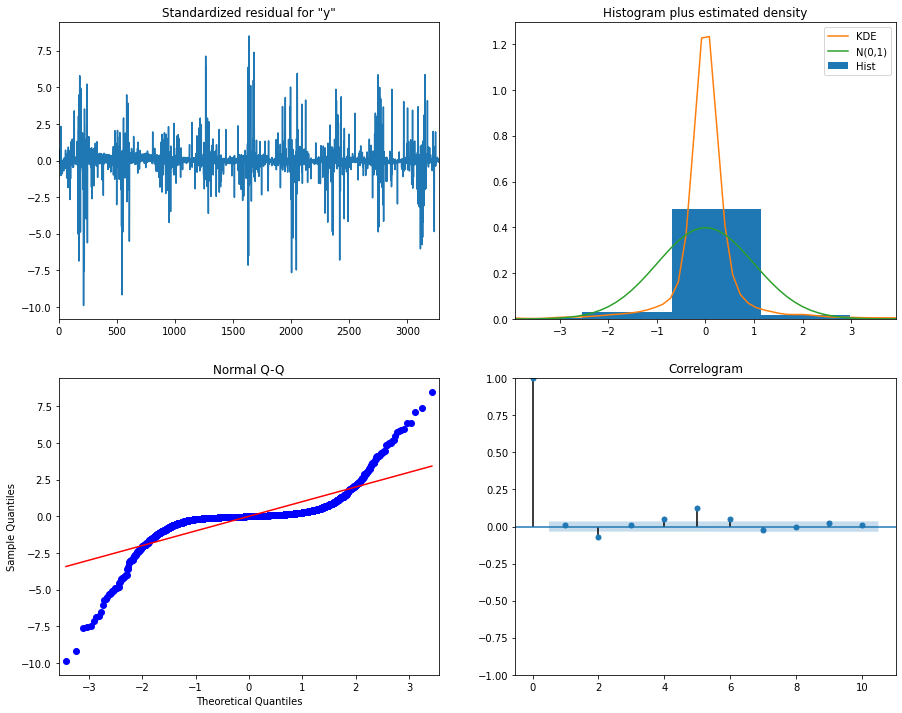

In [ ]:
#잔차 진단 
res.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
res.forecast(100)

array([-0.98036241, -0.58512653,  1.21686911, -0.08957254, -0.91862078,
       -1.17822275,  0.01267963, -1.17233089, -0.40679308, -0.05457403,
        1.22523223, -0.19361832, -0.84008835, -0.83585175,  1.20223132,
       -0.52724707, -0.8461599 , -1.65665131, -0.46120131, -1.51820875,
       -0.23016543, -0.24615114,  1.73936829,  0.30978228, -0.899188  ,
       -0.55345394,  1.18784789, -0.07854216, -0.89126648, -1.13690723,
        0.02103145, -1.13287919, -0.41925361, -0.04796768,  1.18748274,
       -0.19203696, -0.84055446, -0.82987353,  1.205474  , -0.51822622,
       -0.84493127, -1.64741093, -0.45160802, -1.51091517, -0.22997749,
       -0.24073248,  1.73486125,  0.30493308, -0.8956486 , -0.55507366,
        1.1906752 , -0.08267312, -0.88795673, -1.14209711,  0.01639474,
       -1.13604594, -0.41379007, -0.04832828,  1.19839974, -0.18185991,
       -0.83881646, -0.82308861,  1.20783072, -0.50898207, -0.8430075 ,
       -1.63710043, -0.44186749, -1.50259982, -0.23020625, -0.23

In [ ]:
#forecast 시각화
seoul_df['forecast']=res.predict(start = 3653, end = 3956, dynamic= True)
seoul_df[['sum_rn','forecast']].plot(figsize=(12,8))
plt.show()

ValueError: ignored

In [ ]:
#실제 2022년 데이터와 비교
ch_pred = seoul.loc[seoul.date > '2021-12-31',:]

date = []
ogn_date = ch_pred['date']
for i in range(ch_pred.shape[0]) :
    a = str(ogn_date.iloc[i,])
    a = pd.to_datetime(a)
    date.append(a)
ch_pred['date'] = date

ch_pred = ch_pred.loc[:,['date', 'new_wd']]
ch_pred

,date,new_wd
3653,2022-01-01,-234.4286
3654,2022-01-02,-563.3776
3655,2022-01-03,-470.9482
3656,2022-01-04,-585.5228
3657,2022-01-05,-292.3028
...,...,...
3952,2022-10-27,-535.2946
3953,2022-10-28,-284.1164
3954,2022-10-29,-165.0994
3955,2022-10-30,-184.9884


In [ ]:
res.forecast(365)

array([-9.80362411e-01, -5.85126535e-01,  1.21686911e+00, -8.95725369e-02,
       -9.18620779e-01, -1.17822275e+00,  1.26796349e-02, -1.17233089e+00,
       -4.06793084e-01, -5.45740266e-02,  1.22523223e+00, -1.93618318e-01,
       -8.40088347e-01, -8.35851745e-01,  1.20223132e+00, -5.27247074e-01,
       -8.46159898e-01, -1.65665131e+00, -4.61201312e-01, -1.51820875e+00,
       -2.30165433e-01, -2.46151142e-01,  1.73936829e+00,  3.09782280e-01,
       -8.99187997e-01, -5.53453940e-01,  1.18784789e+00, -7.85421620e-02,
       -8.91266478e-01, -1.13690723e+00,  2.10314536e-02, -1.13287919e+00,
       -4.19253607e-01, -4.79676751e-02,  1.18748274e+00, -1.92036955e-01,
       -8.40554459e-01, -8.29873526e-01,  1.20547400e+00, -5.18226219e-01,
       -8.44931270e-01, -1.64741093e+00, -4.51608019e-01, -1.51091517e+00,
       -2.29977490e-01, -2.40732482e-01,  1.73486125e+00,  3.04933085e-01,
       -8.95648603e-01, -5.55073665e-01,  1.19067520e+00, -8.26731242e-02,
       -8.87956733e-01, -